In [3]:
import numpy as np
import matplotlib.pyplot as mpl

Assigning values to the parameters:

In [4]:
# K+ concentrations :

Ki = 0.15 # M, inside
Krest = 0.0035 # Resting Ko. M., outside

# Na+ concentrations
Ni=0.001 # M, inside
Nrest= 0.140 # Resting M., outside

ENa=0.130 #V
Ek=-0.09

# Leak conductances
Gl = 35*1e-9 # Leak conductance of 35 nS.


R = 8.3 # J mol-1 K-1
F = 95600 # C mol-1
T = 273 + 32 # Recording temperature
GKmax = 1e-7 #1/10MOhm. A Guess. Needs a big prefactor?
Cm =3e-10 # f # to refine ? 0.1 uF? of the myelin
El = -0.072 # V resting potential of the leak


#pump coefficient ?

# For now work in concentrations rather than quantities.
dt = 1e-6 # s, 10 milliseconds of delta t
APefflux = 0.002 # M change in Ko with AP.
APtimes = np.arange(0,0.2,0.01) # Roughly 20 APs at 10ms intervals.
times = np.arange(0,2,1e-6)
Km = 0.002 # M the affinity of the ATPase Na+/K+ for K+
Vmax = 0.04 # M s-1 vitesse max ATPase

Djuxta = 1.9*1e-6 #Length of the nodal gap ? example value in m
DK =1.85*1e-9 # coef de diffusion


# Caracteristiques structurales de l'axone/myelin etc

Vint = 6e-15 # litres. Volume of the internode peri-axonal space.
l_internode= 5e-5 #m 50um
r_axon= 0.5*1e-6 #m 0.5um
e_myelin = 250*1e-9 #m 250 nm
V_myelin = (((e_myelin+r_axon)**2*np.pi-r_axon**2*np.pi)*l_internode)*1000#en L
e_submyelin = 2*1e-8 #m 10nm
V_submyelin = (((e_submyelin+r_axon)**2*np.pi-r_axon**2*np.pi)*l_internode)*1000#en L (bonne estimation par Vint)



# 1st model : only looking at submylein/myelin compartment


## 1) Modelisation of K+ extracellular concentration

### Function to mimick the influx of K+ in the myelin during succesion of APs in the axon :
- It's gonna add APefflux to the concentration if we are at a time t where there is a new AP (known by APtimes)
- It's gonna remove the amount of K+ that is imported inside the cell by the ATPase NA+/K+

I have change t, t+dt into t-dt, t


In [26]:
def dK(t,Ko,dt=dt):
    # Tedious calculation to add K efflux at correct time steps.
    d = 0
    if sum(APtimes < (t-dt)) < sum(APtimes < t): #meaning that the t+dt is reaching the timing of a new AP
        d += APefflux # addition of K+ efflux from the neuronal activity
    d -= dt*Vmax*(Ko - Krest)/(Km + (Ko - Krest)) #we also decrease d with the ATPase activity that takes K+ ions inside the cell ( Michaelis-Menten model)
    return d


### Function to generate the evolution of extracellular [K+] upon time:

In [27]:
def Kintegrate(times, Krest=Krest):
    K = np.full(len(times), Krest) #initialisation at the resting concentration of K+
    for i in np.arange(1, len(times)):
        K[i] = K[i-1] + dK(times[i], K[i-1]) #at each time points, we add to the concentration the change dK, that is calculated based on the concentration and the time
    return K

**Model 1 : Only K+ AP efflux and ATPase Na+/K+**

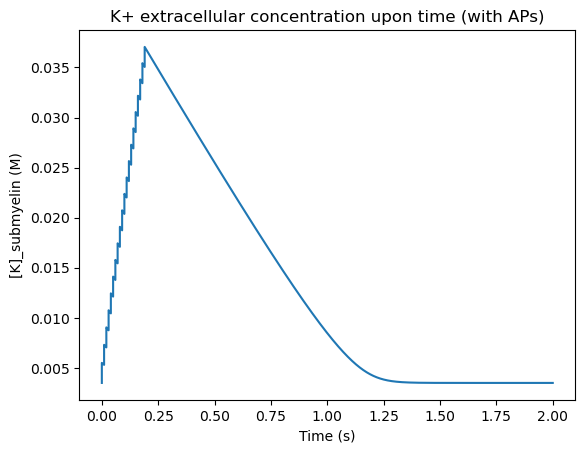

In [31]:
K = Kintegrate(times)
mpl.plot(times, K)
mpl.xlabel("Time (s)")
mpl.ylabel("[K]_submyelin (M)")
mpl.title("K+ extracellular concentration upon time (with APs)")
mpl.show()

I tried to use the FIck Law to model the diffusion of K+ in the sub region. I consider that my two compartment were the paranodal region and the nodal region. They are separated by the distance of the myelin attachement sheat. I consider that at the node, the K+ concentration is the Krest (since it is diluting very fast because the volume of the compartment is big at that place).

In [8]:
def Fick(K,Krest):
    flux=-DK*(K-Krest)/Djuxta #Formula of Fick Law
    K+=flux
    return K



In [17]:
Kfick=K
for i in range(len(Kfick)):
    Kfick[i]=Fick(Kfick[i],Krest)

In [ ]:
mpl.plot(times, Kfick)
mpl.xlabel("Time (s)")
mpl.ylabel("[K]_submyelin (M)")
mpl.title("K+ extracellular concentration upon time (with Fick diffusion)")
mpl.show()

I don't see any difference now that i have put the Djuxta as the distance intranode.

## 2) Modelisation of the voltage of the myelin

If we consider there is no additional K+ current with a specific channel involved, what would be the voltage ?
We could use GHK equation, but simplify it by only considering K+ ions ?
**=> NO here i am looking at the cell like if there was a leak channel only for K+ because i am looking at Ek**

In [150]:
Vm = np.full(len(times), 0,dtype=float)
for i in range (0,len(times)):
    Vm[i] = (R*T/F*np.log(K[i]/Ki))
Vm=Vm*1000


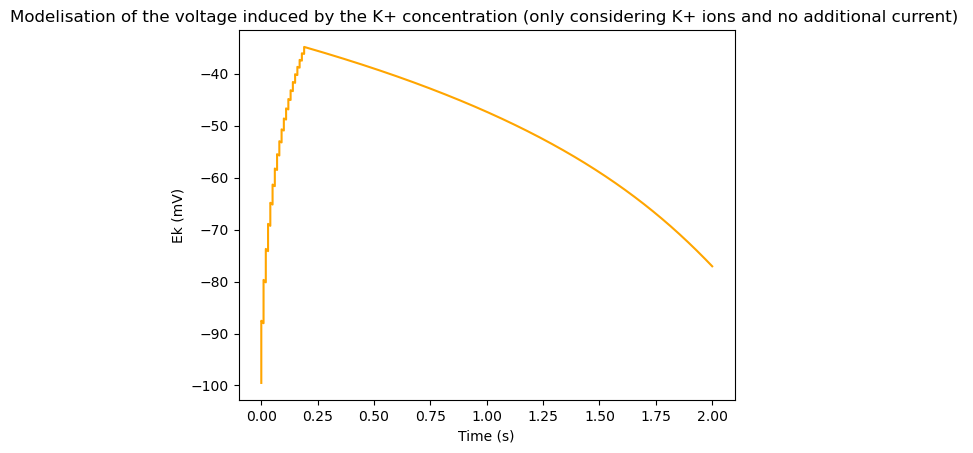

In [151]:
fig,ax=mpl.subplots()
mpl.plot(times, Vm,color='orange')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Ek (mV)")
mpl.title('Modelisation of the voltage induced by the K+ concentration (only considering K+ ions and no additional current) ')
mpl.show()

==> This gives an idea of th tendency of the change : indeed we are gonna have a depolarisation that then comes bck to normal, but it is not granted that there is nothing at all. If there was no current for K+, then the change in concentration would not change anything.

### Function to calculate current through inward rectifier.
Using the formulation of https://link.springer.com/article/10.1007/BF01870103
D(elta)V = V - EK
gK = A/[1 + exp((DV + 15mV)/7mV)]*np.sqrt(Ko)
We can probably just assume the steady-state conductance and neglect any transient regimes.


In [28]:
# V volts, Ko molar.
def I_KIR(V, Ko):
    EK = (R*T/F*np.log(Ko/Ki)) #calculating the Equilibrium potential for K+ with Nernst Law
    DV = V - EK #driving force in V
    return DV*GKmax/(1 + np.exp((DV+0.015)/0.007))*np.sqrt(Ko)

Plotting the IV curve :

In [153]:
V = np.arange(-0.120,0.040,0.002, dtype=float) #in Volts
def I_curve( V,Krest):
    I = np.zeros(len(V))
    for i in np.arange(0, len(V)):
        I[i]= I_KIR(V[i], Krest)
    return I


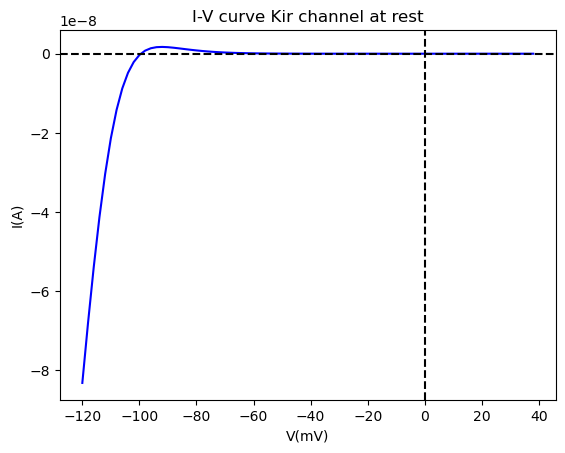

In [154]:
fig,ax=mpl.subplots()
Icurve = I_curve( V,Krest)
mpl.plot(V*1000, Icurve,'blue',label='Ko~0.0035M (Krest)')
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.title("I-V curve Kir channel at rest")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.show()

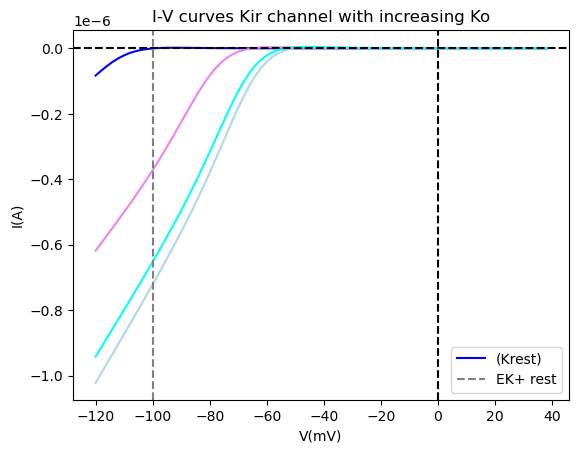

In [156]:

fig,ax=mpl.subplots()
Icurve = I_curve( V,Krest)
mpl.plot(V*1000, Icurve,'blue',label='(Krest)')
Icurve2=I_curve( V,K[100000])
mpl.plot(V*1000, Icurve2,'lightblue')
Icurve3=I_curve( V,K[50000])
mpl.plot(V*1000, Icurve3,'violet')
Icurve4=I_curve( V,0.02)
mpl.plot(V*1000, Icurve4,'cyan')
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.axvline(x=-100,color='grey',linestyle='--',label='EK+ rest')
mpl.title("I-V curves Kir channel with increasing Ko")
ax.legend()
mpl.show()

--> The Eeq of the channel is going to change according to the outside K+ concentration. When it is  high, there is more inward K+ current at the same voltage of the membrane. This is gonna pull the cell back to the resting situation, with influx of K+ directing  the K+ extracellular concentration back to resting value.

In [157]:
def Ileak(V):
    return Gl*(V-El)

In [158]:
V = np.arange(-0.120,0.040,0.002, dtype=float)
def Ileak_curve( V):
    I = np.zeros(len(V))
    for i in np.arange(0, len(V)):
        I[i]= Ileak(V[i])
    return I

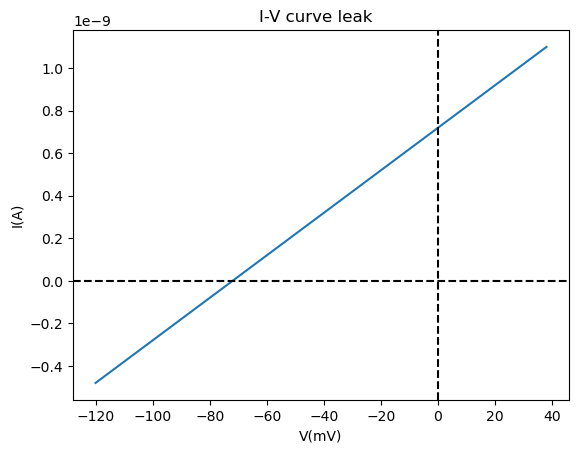

In [159]:
fig,ax=mpl.subplots()
Icurve = Ileak_curve( V)
mpl.plot(V*1000, Icurve)
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.title("I-V curve leak  ")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.show()

In [18]:
def I_h(V,dt,times, Gh):
    P_open=np.full(len(V),1.,dtype=float)
    Ih=np.zeros(len(V),dtype=float)
    for i in range (len(V)-1):
        P_open[i+1] = P_open[i] + dt*(0.63*np.exp(-0.063*(V[i]*1000+73.2))*(1-P_open[i])-0.63*np.exp(0.079*(V[i]*1000+73.2))*P_open[i])
        Ih[i]=Gh*P_open[i]*(V[i]-Ek)
    return Ih

In [21]:
V = np.arange(-0.120,0.040,0.002, dtype=float)


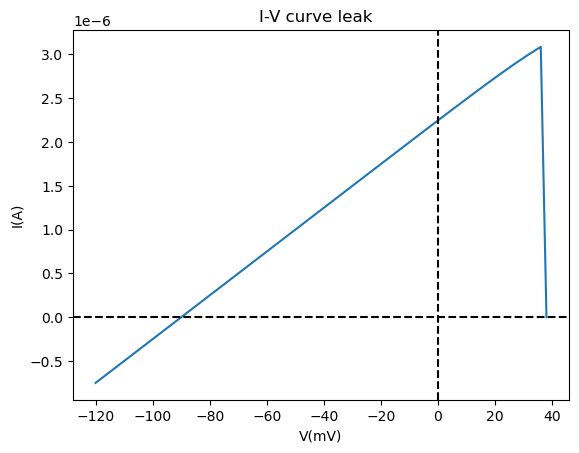

In [22]:
fig,ax=mpl.subplots()
Icurve = I_h(V,dt,times,Gh=25*1e-6)
mpl.plot(V*1000, Icurve)
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.title("I-V curve leak  ")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.show()

### I upon Ko at the resting potential (El=-50mV)
I am looking at the plot I upon  Ko, at a given V (El). It might don't be pertinent since the V is changing with KO changing.

In [64]:
I_KO = I_KIR(np.full(len(K),-0.05),K) #here i try V as the El

In [ ]:
fig,ax=mpl.subplots()
mpl.plot(K, I_KO, color='green',linestyle='--')
ax.set_xlabel("KO (M)")
ax.set_ylabel("I (A)")
mpl.title('I (in Kir) upon extracellular K+ concentration')
mpl.show()

### Integrating the current through the Kir into change in voltage

**Test 3:**
With Im= Ikir+ Icapactive + Ileak = 0
-Ikir =Icap + Ileak

V(t+dt)=V(t) + dt/Cm * (-Ikir - Gl(V(t)-El))


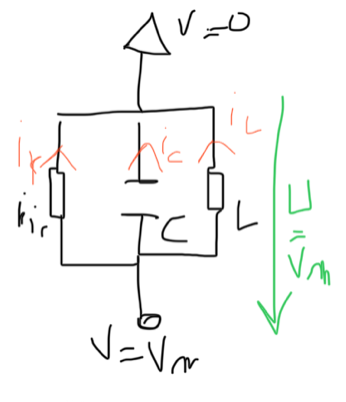
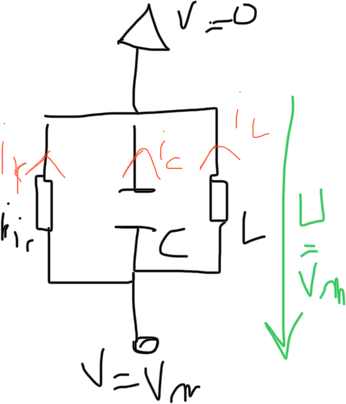

In [38]:
def Vintegrate(times,Ko,El,Gh=25*1e-6):
    V = np.full(len(times), El) #Initialisation so that the V[0] is El (with conversion in mV)
    P_open=1 #probability of HCN to be open at t=0.
    for i in np.arange(0, len(times)-1):
        P_open+= dt*(0.63*np.exp(-0.063*(V[i]*1000+73.2))*(1-P_open)-0.63*np.exp(0.079*(V[i]*1000+73.2))*P_open)
        Ih=Gh*P_open*(V[i]-Ek)
        V[i+1]= V[i]+ dt/Cm *(-I_KIR(V[i],Ko[i])-Gl*(V[i]-El)-Ih)
    return V

In [39]:
V = Vintegrate(times,K,El)
V

array([-0.072     , -0.0735    , -0.07487483, ..., -0.08997263,
       -0.08997263, -0.08997263], shape=(2000000,))

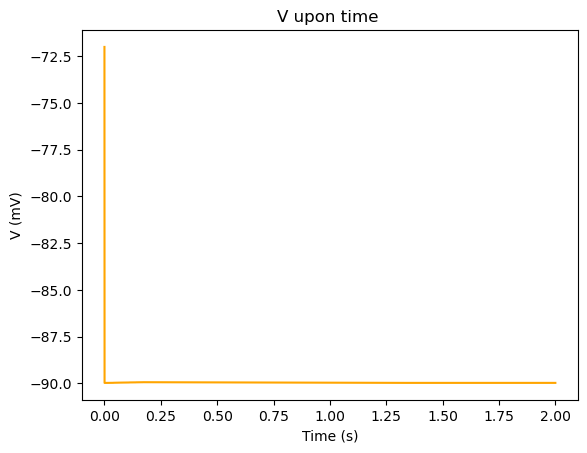

In [40]:
fig,ax=mpl.subplots()
mpl.plot(times, V*1000,color='orange')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.show()

### Changing Gmax of Kir

In [238]:
GKmax_test = np.arange(1e-9,1e-6,(1e-6-1e-9)/5)

In [239]:
V=np.full((len(GKmax_test),len(times)),0.)
print(np.shape(V))

(5, 2000000)


In [213]:

for i in range(len(GKmax_test)):
    GKmax=GKmax_test[i]
    V[i] = Vintegrate(times, K, El)
print(V)

[[-0.072      -0.072      -0.072      ... -0.07200069 -0.07200069
  -0.07200069]
 [-0.072      -0.072      -0.07200001 ... -0.07213659 -0.07213659
  -0.07213659]
 [-0.072      -0.072      -0.07200002 ... -0.07226941 -0.07226942
  -0.07226942]
 [-0.072      -0.07200001 -0.07200004 ... -0.07239901 -0.07239901
  -0.07239901]
 [-0.072      -0.07200001 -0.07200005 ... -0.07252526 -0.07252526
  -0.07252526]]


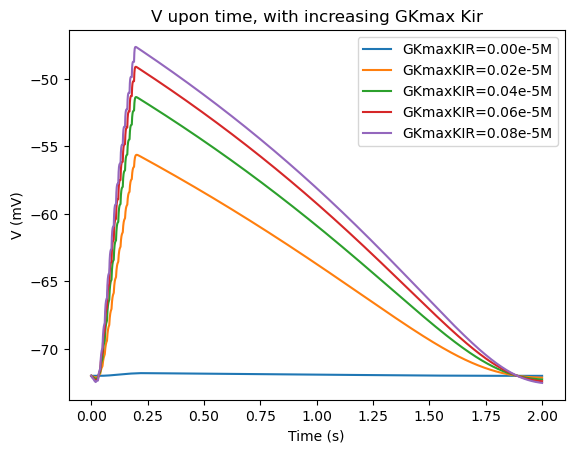

In [214]:

fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'GKmaxKIR={GKmax_test[i]*1e5:.2f}e-5M')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with increasing GKmax Kir")
mpl.legend()
mpl.show()

-> The GKMAX factor is gonna influence the amplitude of the deploarisation of the myelin.

### Changing Cm

In [217]:
Cm_test=np.arange(Cm,1e-7,(1e-7-Cm)/5)
print(Cm_test)

[3.000e-10 2.024e-08 4.018e-08 6.012e-08 8.006e-08]


In [218]:
V=np.full((len(Cm_test),len(times)),0.)


In [219]:
for i in range(len(Cm_test)):
    Cm=Cm_test[i]
    V[i] = Vintegrate(times, K, El)
print(V)

[[-0.072      -0.072      -0.07200001 ... -0.0720684  -0.0720684
  -0.0720684 ]
 [-0.072      -0.072      -0.072      ... -0.07008268 -0.07008268
  -0.07008269]
 [-0.072      -0.072      -0.072      ... -0.06882806 -0.06882807
  -0.06882807]
 [-0.072      -0.072      -0.072      ... -0.06863337 -0.06863337
  -0.06863337]
 [-0.072      -0.072      -0.072      ... -0.06877111 -0.06877112
  -0.06877112]]


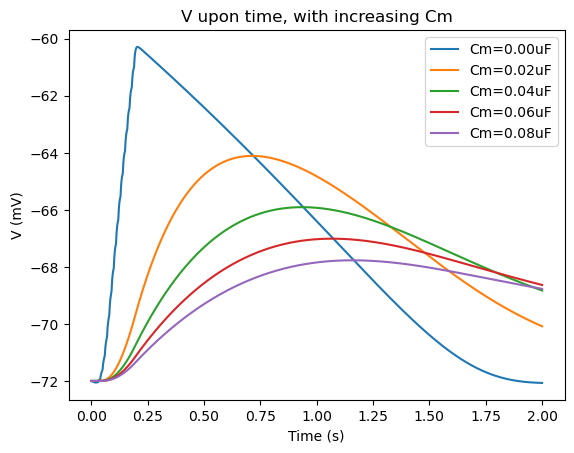

In [220]:
fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'Cm={Cm_test[i]*1e6:.2f}uF')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with increasing Cm")
mpl.legend()
mpl.show()

-> the capacitance of the myelin is gonna influence the timing of the maximum of the depolarisation
It seems that in the article, the depolarisation is quite fast, indicating a pretty low capacitance.

### Changing Gl

with GKmax being 1e-4M, and Cm being 3e-10F

In [241]:
Gl_test=np.arange(1e-9,1e-7,(1e-9-1e-7)/5)
print(Gl_test)

[]


In [232]:
V=np.full((len(Gl_test),len(times)),0.)
print(V)

[]


In [231]:
for i in range(len(Gl_test)):
    Gl=Gl_test[i]
    V[i] = Vintegrate(times, K, El)
print(V)

[]


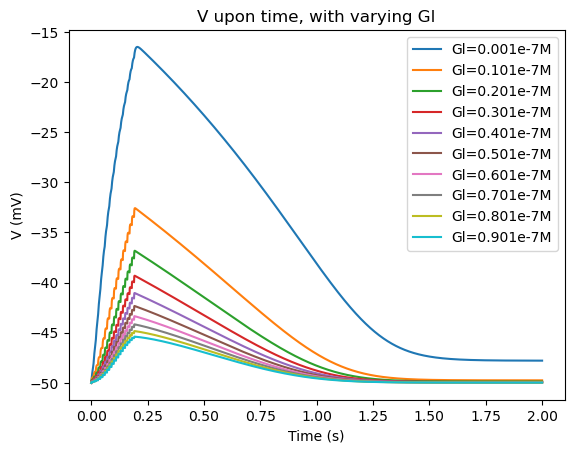

In [147]:
fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'Gl={Cm_test[i]*1e7:.2f}1e-7M')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with varying Gl")
mpl.legend()
mpl.show()

-> The leaking conductance influences the amplitude of the depolarisation as expected. Lower leakage leads to stronger depolarisation.

### Changing Vmax

with GKmax being 1e-4M, and Cm being 3e-10F, Gl being 0.1E-7


In [242]:
Vmax_test=np.arange(0.01,0.05,0.01)


In [243]:
K_test=np.full((len(Vmax_test),len(times)),0.)


In [244]:
for i in range(len(Vmax_test)):
    Vmax=Vmax_test[i]
    K_test[i] = Kintegrate(times, Krest)


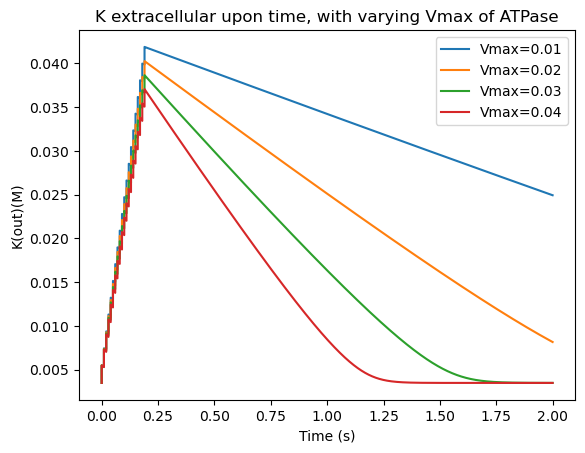

In [246]:
fig, ax = mpl.subplots()
for i in range (len(K_test)):
    mpl.plot(times, K_test[i] , label=f'Vmax={Vmax_test[i]:.2f}')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K(out)(M)")
mpl.title("K extracellular upon time, with varying Vmax of ATPase")
mpl.legend()
mpl.show()

In [247]:
V=np.full((len(K_test),len(times)),0.)

In [248]:
for i in range(len(K_test)):
    V[i] = Vintegrate(times, K_test[i], El)

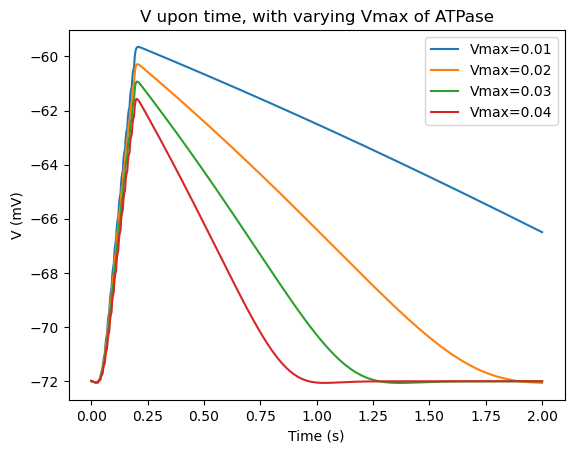

In [249]:
fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'Vmax={Vmax_test[i]:.2f}')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with varying Vmax of ATPase")
mpl.legend()
mpl.show()

-> it influences the "tau" of the repolarisation, not so much the amplitude, neither the timing of max depolarisation.

**=> So what really matters is the ratio between GL and GKmax, that will dictate the amplitude of the depolarisation. The capacitance is quite low.**

**Trying to adjust the parameters the best way :**


In [251]:
GKmax = 1e-7 #1/10MOhm. A Guess. Needs a big prefactor?
Cm =3e-10 # f # to refine ? 0.1 uF? of the myelin
Vmax = 0.04 # M s-1 vitesse max ATPase
Gl = 35*1e-9 # Leak conductance of 35 nS.

In [252]:
V = Vintegrate(times, K, El)

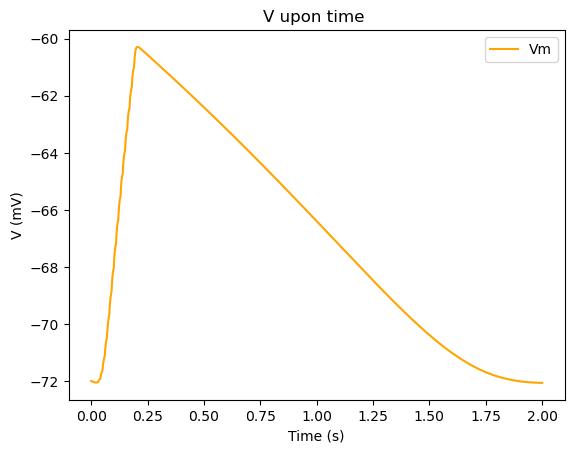

In [253]:
fig, ax = mpl.subplots()
mpl.plot(times, V * 1000, color='orange', label = "Vm")
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.legend()
mpl.show()

# 2nd model : looking at concentrations in compartments

In [9]:
def I_KIR_2(V, c_ext,c_int):
    EK = (R*T/F*np.log(c_ext/c_int)) #calculating the Equilibrium potential for K+ with Nernst Law
    DV = V - EK #driving force in V
    return DV*GKmax/(1 + np.exp((DV+0.015)/0.007))*np.sqrt(c_ext)

In [19]:
def E( c_ext,c_int):
    return(R*T/F)*np.log(c_ext/c_int)

### Integration of leak, Kir current and ATPase pumping over time

In [43]:
submyelinK = np.full(len(times), Krest)
myelinK = np.full(len(times), Ki)
extK = np.full(len(times),Krest)  #on considère que cet espace est suffisamment grand pour rester à la même concentration Krest

In [44]:
V=np.full(len(times),El)
IKIRint=np.full(len(times),0.)
IKIRext=np.full(len(times),0.)
for i in np.arange(0, len(times)-1):
    #Changements de concentration avec ATPase
    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    if sum(APtimes < (times[i]-dt)) < sum(APtimes < times[i]): #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i+1] += APefflux # addition of K+ efflux from the neuronal activity
    submyelinK[i+1] -= dt*Vmax*(submyelinK[i] - Krest)/(Km + (submyelinK[i] - Krest))
    myelinK[i+1]+= (dt*Vmax*(submyelinK[i] - Krest)/(Km + (submyelinK[i] - Krest)))*Vint/V_myeline

    #Changement de concentration avec iKIR (avec l'ext et avec le compartiment sous-myeline)
    IKIRint[i]=I_KIR_2(V[i],submyelinK[i],myelinK[i])
    submyelinK[i+1]+= IKIRint[i]*dt/(Vint*F)
    myelinK[i+1]-=IKIRint[i]*dt/(V_myeline*F)

    IKIRext[i]=I_KIR_2(V[i],extK[i],myelinK[i])
    myelinK[i+1]-=IKIRext[i]*dt/(V_myeline*F)

    #Changement de concentration avec leak en dehors de la cellule coté sousmyéline et coté extracellulaire
    Ek=E(submyelinK[i],myelinK[i])
    ratio_Gl_Na_K= (El-Ek)/(ENa-El)
    GlK= 1/(1+ratio_Gl_Na_K)
    #GlNa=ratio_Gl_Na_K/(1+ratio_Gl_Na_K)
    ileak=GlK*Gl*(V[i]-El) #ne prends en compte que la composante potassique du courant de fuite
    myelinK[i+1]-=ileak*dt/(V_myeline*F)
    submyelinK[i+1]+=ileak*dt/(Vint*F)

    Ek=E(extK[i],myelinK[i])
    ratio_Gl_Na_K= (El-Ek)/(ENa-El)
    GlK= 1/(1+ratio_Gl_Na_K)
    ileak=GlK*Gl*(V[i]-El)
    myelinK[i+1]-=ileak*dt/(V_myeline*F)

    #Calcul du potentiel de membrane, qui est le résultat de tous les courants
    V[i+1]= V[i]- dt/Cm *(+IKIRint[i]+IKIRext[i]+2*Gl*(V[i]-El))


In [46]:
print(ratio_Gl_Na_K)

0.1383100443756813


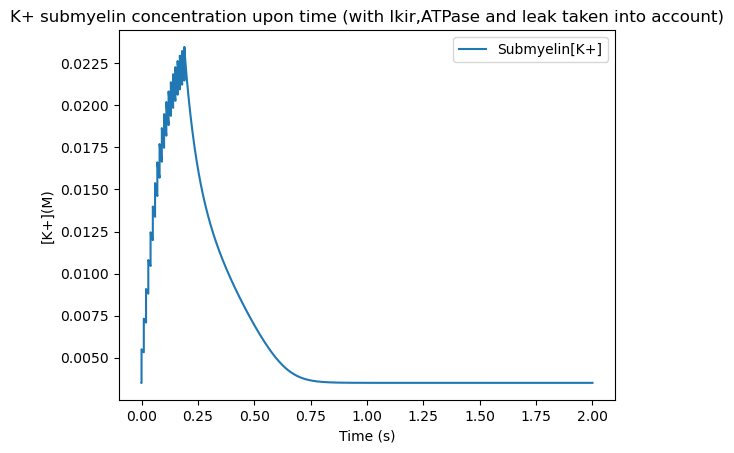

In [45]:
mpl.plot(times, submyelinK, label="Submyelin[K+]")
mpl.xlabel("Time (s)")
mpl.ylabel("[K+](M)")
mpl.title("K+ submyelin concentration upon time (with Ikir,ATPase and leak taken into account)")
mpl.legend()
mpl.show()

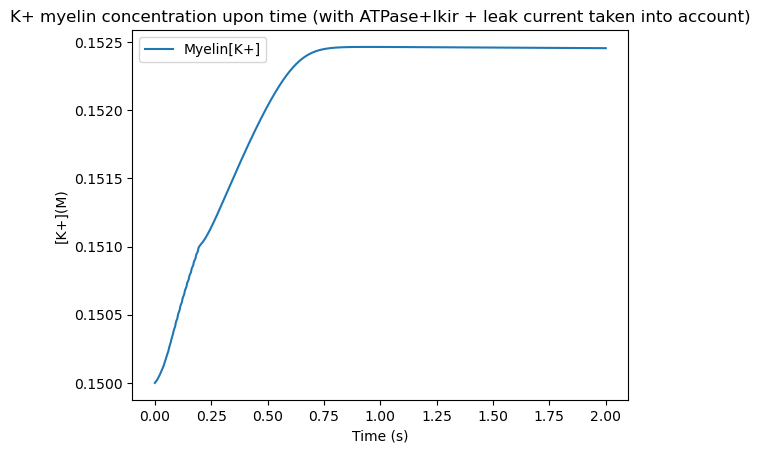

In [47]:
mpl.plot(times, myelinK, label="Myelin[K+]")
mpl.xlabel("Time (s)")
mpl.ylabel("[K+](M)")
mpl.title("K+ myelin concentration upon time (with ATPase+Ikir + leak current taken into account)")
mpl.legend()
mpl.show()

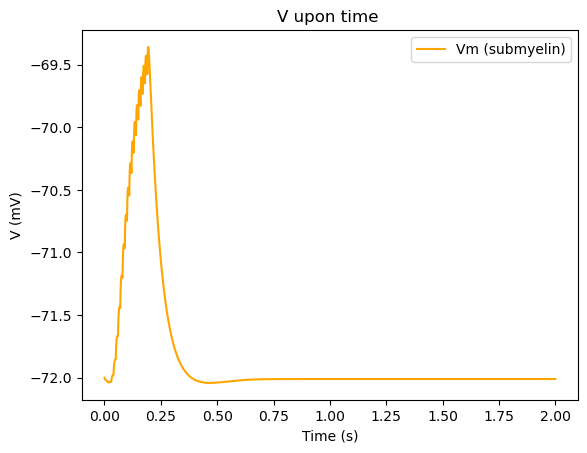

In [48]:
fig, ax = mpl.subplots()
mpl.plot(times, V * 1000, color='orange', label = "Vm (submyelin)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.legend()
mpl.show()

-> we have a inward current through the KIR. as expected.

## Test rapport 2)a

In [5]:
V= np.full(len(times), El) #Initialisation so that the V[0] is El (with conversion in mV)
submyelinK = np.full(len(times), Krest)
myelinK = np.full(len(times), Ki)
extK = np.full(len(times),Krest)

for i in np.arange(0, len(times)-1):
    #Changements de concentration avec ATPase
    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    if sum(APtimes < (times[i]-dt)) < sum(APtimes < times[i]): #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i+1] += APefflux # addition of K+ efflux from the neuronal activity
    atpase_d=dt*Vmax*(submyelinK[i] - Krest)/(Km + (submyelinK[i] - Krest))
    submyelinK[i+1] -= atpase_d
    myelinK[i+1]+= atpase_d*V_submyelin/V_myelin

    #Changement de concentration avec leak en dehors de la myeline

    #ratio_Pl_K_Na= (Nrest-Ni*np.exp(El*F/R*T))/(myelinK[i]*np.exp(El*F/R*T)-Krest)
    Kleak= 1*(myelinK[i]-myelinK[0])*dt #assumption of the Pk to be 1
    myelinK[i+1]-=Kleak

    Ikir=I_KIR(R,T,F,GKmax,V[i],submyelinK[i], myelinK[i])
    submyelinK[i + 1] += Ikir * dt / (Vint * F)
    myelinK[i + 1] -= Ikir * dt / (V_myelin * F)



    V[i+1]= V[i]+ dt/Cm *(-Ikir-Gl*(V[i]-El))

NameError: name 'I_KIR' is not defined

In [ ]:

fig,ax=mpl.subplots()
mpl.plot(times, V*1000,color='orange')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.show()

ig,ax=mpl.subplots()
mpl.plot(times, submyelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.show()
ig,ax=mpl.subplots()
mpl.plot(times, myelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.show()